In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LSTM模型

这里的timesteps为步数，features为维度 这里我们的数据是1维的

LSTM 20 two hidden layers output 1 number error percentage is around: 4-5

LSTM: [samples, timesteps, features]

CNN: # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]

In [2]:
from keras.layers import TimeDistributed
from keras import models
from keras.layers import Embedding, SimpleRNN
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

In [3]:
#LSTM model compile
def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it. 
    #input_shape=(None, n_steps:time step using to predict the current GDU, n_features:1 for univariate series)
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,1,1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu',return_sequences = True))
    model.add(LSTM(20,activation='relu'))
    model.add(Dense(1)) #output layer
    model.compile(optimizer='adam', loss='mae', metrics=['mape']) #change loss function
    return model

# Data pre-processing

In [5]:
pwd


'/content'

In [6]:
import pandas as pd 
df = pd.read_csv('/content/drive/MyDrive/Syngenta research project/Datasets for the research/Dataset_2.csv',parse_dates=["date"]).drop(["Forecast(GDUs for site_0)","Lower Confidence Bound(GDUs for site_0)","Upper Confidence Bound(GDUs for site_0)"],axis =1)

#select historical data 11 years
Selected_Gdu=(df['date']>='2009-01-01') & (df['date']<='2019-12-31')
df_historical = df.loc[Selected_Gdu]

In [7]:
df

,date,GDUs for site_0
0,2009-01-01,11.438115
1,2009-01-02,11.603950
2,2009-01-03,11.606865
3,2009-01-04,11.917281
4,2009-01-05,12.283949
...,...,...
5017,2022-09-27,NaN
5018,2022-09-28,NaN
5019,2022-09-29,NaN
5020,2022-09-30,NaN


In [8]:
#predicted the day of Gdu based on yesterday's Gdu
#shift the previous temperature to the current day
Gdu_pre = df_historical['GDUs for site_0'].to_frame().shift(1).rename(columns = {'GDUs for site_0':'GDUs_0_previous'})
Gdu_act = df_historical['GDUs for site_0'].to_frame().rename(columns = {'GDUs for site_0':'GDUs_0_actual'})

#Concatenate the actual and predicted temperature
one_step_data = pd.concat([Gdu_pre,Gdu_act],axis = 1)

df_supervised = one_step_data[1:]
df_supervised.head()

,GDUs_0_previous,GDUs_0_actual
1,11.438115,11.603950
2,11.603950,11.606865
3,11.606865,11.917281
4,11.917281,12.283949
5,12.283949,12.670198


In [10]:
from sklearn.model_selection import train_test_split

# Train-test-validation split
train_size = int(len(df_supervised)*10/11)
train, test = df_supervised[0:train_size],df_supervised[train_size:len(df_supervised)]
print(train.shape,test.shape)

(3650, 2) (366, 2)


In [11]:
train

,GDUs_0_previous,GDUs_0_actual
1,11.438115,11.603950
2,11.603950,11.606865
3,11.606865,11.917281
4,11.917281,12.283949
5,12.283949,12.670198
...,...,...
3646,11.174366,11.361033
3647,11.361033,11.163532
3648,11.163532,11.575615
3649,11.575615,11.204366


Observations: 4016
Training Observations: 3650
Testing Observations: 366


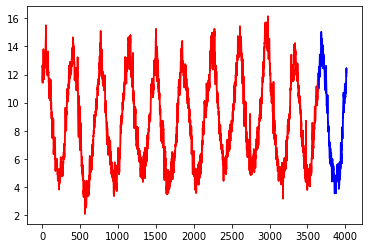

In [13]:
from matplotlib import pyplot as plt

print('Observations: %d' % (len(df_supervised)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
plt.plot(train, c='red')
plt.plot(test, c='blue')
plt.show()

K-fold

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Observations: 1218
Training Observations: 610
Testing Observations: 608
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Observations: 1826
Training Observations: 1218
Testing Observations: 608
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Observations: 2434
Training Observations: 1826
Testing Observations: 608
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Observations: 3042
Training Observations: 2434
Testing Observations: 608
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Observations: 3650
Training Observations: 3042
Testing Observations: 608


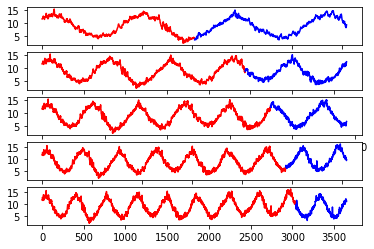

In [ ]:
#visualize the k-fold

from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
n_splits = 5
splits = TimeSeriesSplit(n_splits)
plt.figure(1)

index = 1
all_scores = []
for train_index, validation_index in splits.split(train):
  for i in range(n_splits):
    print('processing fold #', i)
  train_kx = train.iloc[train_index,1]
  train_ky = train.iloc[train_index,1:2]
  val_kx = train.iloc[validation_index,1]
  val_ky = train.iloc[validation_index,1:2]
  print('Observations: %d' % (len(train_kx) + len(val_kx)))
  print('Training Observations: %d' % (len(train_kx)))
  print('Testing Observations: %d' % (len(val_kx)))
  plt.subplot(510 + index)
  plt.plot(train_kx, c='red')
  plt.plot(val_kx, c='blue')
  index += 1

plt.show()

# CNN+LSTM

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
n_features = 1
n_seq = 1
n_steps = 1
num_epochs = 10
batch_size = 32
k = 5

splits = TimeSeriesSplit(k)

all_scores = []
for train_index, validation_index in splits.split(train):
  # Prepare the training data 
  train_kx = train.iloc[train_index,[0]]
  train_ky = train.iloc[train_index,[1]]
  
  # Prepare the validation data
  val_kx = train.iloc[validation_index,[0]]
  val_ky = train.iloc[validation_index,[1]]
  
  #turn to array
  train_kx= np.array(train_kx)
  val_kx = np.array(val_kx)
  print(train_kx.shape)
  print(val_kx.shape)
  
  # reshape input from 2 dims to be 4 dims [samples, subsequences, timesteps, features]
  #n_seq, n_steps, n_features
  train_kx_reshape = train_kx.reshape((train_kx.shape[0],n_seq, n_steps, n_features))
  val_kx_reshape = val_kx.reshape((val_kx.shape[0],n_seq, n_steps, n_features))
  print(train_kx_reshape.shape)
  print(val_kx_reshape.shape)


  # Build the Keras model (already compiled)
  model = build_model()
  # Train the model (in silent mode, verbose=0)
  model.fit(train_kx_reshape, train_ky,epochs=num_epochs, batch_size=batch_size, verbose=0)
  # Evaluate the model on the validation data
  val_mae, val_mape = model.evaluate(val_kx_reshape, val_ky, verbose=0)
  all_scores.append(val_mae)


(610, 1)
(608, 1)
(610, 1, 1, 1)
(608, 1, 1, 1)
(1218, 1)
(608, 1)
(1218, 1, 1, 1)
(608, 1, 1, 1)
(1826, 1)
(608, 1)
(1826, 1, 1, 1)
(608, 1, 1, 1)
(2434, 1)
(608, 1)
(2434, 1, 1, 1)
(608, 1, 1, 1)
(3042, 1)
(608, 1)
(3042, 1, 1, 1)
(608, 1, 1, 1)


In [23]:
all_scores

[0.33299073576927185,
 0.35386908054351807,
 0.3852403461933136,
 0.3396063446998596,
 0.3532567620277405]

In [24]:
np.mean(all_scores)

0.3529926538467407

In [25]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [26]:
history_dict = history.history
history_dict.keys()

NameError: ignored

change epochs

In [27]:
num_epochs = 100
batch_size= 32
k = 5
splits = TimeSeriesSplit(k)

all_mape_histories = []
for train_index, validation_index in splits.split(train):
  # Prepare the training data 
  train_kx = train.iloc[train_index,[0]]
  train_ky = train.iloc[train_index,[1]]
  
  # Prepare the validation data
  val_kx = train.iloc[validation_index,[0]]
  val_ky = train.iloc[validation_index,[1]]
  
  #turn to array
  train_kx = np.array(train_kx)
  val_kx = np.array(val_kx)
  print(train_kx.shape)
  print(val_kx.shape) 

  # reshape input to be [samples, time steps, features]
  train_kx_reshape = train_kx.reshape((train_kx.shape[0],1,1,1))
  val_kx_reshape = val_kx.reshape((val_kx.shape[0],1,1,1))
  print(train_kx_reshape.shape)
  print(val_kx_reshape.shape)

  # Build the Keras model (already compiled)
  model = build_model()
  # Train the model (in silent mode, verbose=0)
  history = model.fit(train_kx_reshape, train_ky,
                      validation_data=(val_kx_reshape, val_ky),
                      epochs=num_epochs, 
                      batch_size=batch_size, 
                      verbose=0)
  
  mape_history = history.history['val_mape']
  all_mape_histories.append(mape_history)

(610, 1)
(608, 1)
(610, 1, 1, 1)
(608, 1, 1, 1)
(1218, 1)
(608, 1)
(1218, 1, 1, 1)
(608, 1, 1, 1)
(1826, 1)
(608, 1)
(1826, 1, 1, 1)
(608, 1, 1, 1)
(2434, 1)
(608, 1)
(2434, 1, 1, 1)
(608, 1, 1, 1)
(3042, 1)
(608, 1)
(3042, 1, 1, 1)
(608, 1, 1, 1)


In [28]:
average_mape_history = [np.mean([x[i] for x in all_mape_histories]) for i in range(num_epochs)]
average_mape_history

[39.815826416015625,
 10.87703366279602,
 7.549234819412232,
 5.723774051666259,
 5.100897789001465,
 4.81180510520935,
 4.944809246063232,
 4.883619499206543,
 4.846142292022705,
 4.545289993286133,
 4.622617626190186,
 4.548041582107544,
 4.885692977905274,
 4.753170394897461,
 4.585883140563965,
 4.5859781265258786,
 4.713778448104859,
 4.520397567749024,
 4.579729223251343,
 4.661923456192016,
 4.768205690383911,
 4.557590818405151,
 4.550825214385986,
 4.729895305633545,
 4.677537631988526,
 4.6850580215454105,
 4.554048204421997,
 4.542193460464477,
 4.488885879516602,
 4.59444146156311,
 4.451716613769531,
 4.523859977722168,
 4.471672010421753,
 4.613105249404907,
 4.558431196212768,
 4.457757139205933,
 4.665835809707642,
 4.497923707962036,
 4.5966880321502686,
 4.535251522064209,
 4.593705177307129,
 4.750713348388672,
 4.534055614471436,
 4.580800771713257,
 4.560017347335815,
 4.596968078613282,
 4.551870203018188,
 4.461600589752197,
 4.438568496704102,
 4.482274627685546

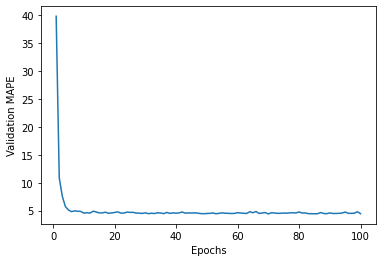

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mape_history) + 1), average_mape_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAPE')
plt.show()

# Validate

In [30]:
test.head()

,GDUs_0_previous,GDUs_0_actual
3651,11.038115,11.635199
3652,11.635199,11.884366
3653,11.884366,11.643949
3654,11.643949,11.784782
3655,11.784782,11.970617


In [31]:
testx = test.iloc[:,[0]]
testy = test.iloc[:,[1]]

In [32]:
testx.shape

(366, 1)

In [33]:
testx = np.array(testx)

In [34]:
testx_reshape = testx.reshape((testx.shape[0],1,1,1))

In [35]:
testPredict = model.predict(testx_reshape)

In [36]:
import math
from sklearn.metrics import mean_squared_error
testScore = math.sqrt(mean_squared_error(testy, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.43 RMSE


# Forecast

In [37]:
df_historical

,date,GDUs for site_0
0,2009-01-01,11.438115
1,2009-01-02,11.603950
2,2009-01-03,11.606865
3,2009-01-04,11.917281
4,2009-01-05,12.283949
...,...,...
4012,2019-12-27,11.799784
4013,2019-12-28,11.711865
4014,2019-12-29,12.456031
4015,2019-12-30,12.135616


In [38]:
x_input = df_historical.iloc[:,[1]]
x_input = np.array(x_input)
x_input = x_input.reshape((x_input.shape[0], n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[11.394855 ]
 [11.55776  ]
 [11.560622 ]
 ...
 [12.3907385]
 [12.078281 ]
 [11.825285 ]]


In [39]:
yhat.shape

(4017, 1)

In [40]:
import pandas as pd 
df = pd.read_csv('/content/drive/MyDrive/Syngenta research project/Datasets for the research/Dataset_2.csv',parse_dates=["date"]).drop(["GDUs for site_0","Lower Confidence Bound(GDUs for site_0)","Upper Confidence Bound(GDUs for site_0)"],axis =1)

#select historical data 11 years
future_Gdu=(df['date']>='2020-01-01')
df_future = df.loc[future_Gdu]

In [41]:
df_future

,date,Forecast(GDUs for site_0)
4017,2020-01-01,11.730721
4018,2020-01-02,11.646725
4019,2020-01-03,11.819333
4020,2020-01-04,11.311299
4021,2020-01-05,11.067752
...,...,...
5017,2022-09-27,5.633804
5018,2022-09-28,5.768527
5019,2022-09-29,5.600112
5020,2022-09-30,5.640293


In [42]:
actual_Gdu = df_future.iloc[:,1]
actual_Gdu = np.array(actual_Gdu)
actual_Gdu.shape

(1005,)

In [43]:
yhat_future = yhat[-1005:]

In [44]:
forecastScore = math.sqrt(mean_squared_error(actual_Gdu, yhat_future))
print('Test Score: %.2f RMSE' % (forecastScore))

Test Score: 3.67 RMSE


# Time step = 30

,date,GDUs for site_0
0,2009-01-01,11.438115
1,2009-01-02,11.603950
2,2009-01-03,11.606865
3,2009-01-04,11.917281
4,2009-01-05,12.283949
...,...,...
4012,2019-12-27,11.799784
4013,2019-12-28,11.711865
4014,2019-12-29,12.456031
4015,2019-12-30,12.135616


array([11.438115, 11.60395 , 11.606865, ..., 12.456031, 12.135616,
       11.876866])

In [ ]:
x

array([[11.438115 , 11.60395  , 11.606865 , 11.917281 , 12.283949 ,
        12.670198 , 12.495617 , 12.606867 , 12.089366 , 11.831865 ,
        11.419784 , 11.645617 , 12.347282 , 12.343116 , 12.5602   ,
        12.260615 , 13.431866 , 13.805616 , 13.573116 , 12.667281 ,
        12.1352005, 12.360199 , 12.598532 , 12.774783 , 11.651867 ,
        11.769365 , 12.007699 , 12.23895  , 12.9402   , 13.465199 ]])